### Data Usage
For this whole project, the Celeb-DF v2 dataset was used to train a CNN-LSTM model to predict whether a video is a deepfake or a real video. 
The dataset is composed of:
* 590 real videos
* 5639 deepfakes. 

In [2]:
from pathlib import Path
# Setup training, testing, and validation paths of the videos
videos_path = Path("data/CelebDF(v2)")
train_vids_dir = videos_path / "train"
validation_vids_dir = videos_path / "validation"
test_vids_dir = videos_path / "test"
train_vids_dir, validation_vids_dir, test_vids_dir

(PosixPath('data/CelebDF(v2)/train'),
 PosixPath('data/CelebDF(v2)/validation'),
 PosixPath('data/CelebDF(v2)/test'))

In [3]:
import os
from typing import Dict, List, Tuple
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in the target directories"""
    # 1. Get the class names by scanning the entire target directory
    classes = sorted([entry.name for entry in list(os.scandir(directory))])
    
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}...please check file structure")
    
    # 3. Create a list of index labels (computers perfer numbers over strings for labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx
find_classes(train_vids_dir.__str__())

(['fake', 'real'], {'fake': 0, 'real': 1})

### Turning Videos into Frames
Because videos are large and very difficult to process, they will be converted by their frames into images so that they can be stored effectively. 
* It is much easier to apply transformations to stored images than it is to iterate through each video, through each frame of each video. 
* Iterating though images can be done with 2-D Convolution, while iterating through videos would require expensive 3-D Convolution

torch.Size([3, 500, 942])


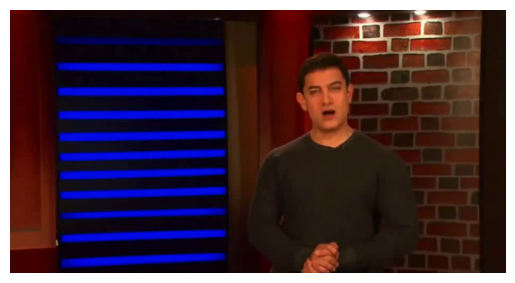

In [95]:
import matplotlib.pyplot as plt
from torchcodec.decoders import VideoDecoder

vd = VideoDecoder("data/CelebDF(v2)/test/real/id0_0000.mp4")
i = 0
for frame in vd:  # type: ignore
    image = frame # Get one frame of the video to work with...
    break
plt.imshow(image.permute(1, 2, 0))
plt.axis(False)
print(image.shape)

/tmp/ipykernel_3081/22090838.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image)


(89, 90)

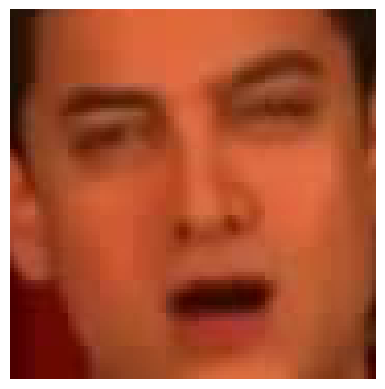

In [100]:
import face_recognition as fr
from torchvision.transforms import v2
import torch

image = torch.tensor(image)
numpy = image.numpy()
locations = fr.face_locations(img=numpy)[0]
top, right, bottom, left = locations[0], locations[1], locations[2], locations[3]
# Apply transforms
image = v2.functional.to_pil_image(pic=image.permute(2, 0, 1))
image = v2.functional.crop(inpt=image, top=top, left=left, height=abs(top-bottom), 
                           width=abs(right-left))
plt.imshow(image)
plt.axis(False)
height, width = image.size # type: ignore
height, width

### Preprocessing
Now that it is clearly possible to break up a video into frames, and then filter out the face from all their frames, a custom transform must be written so that videos are stored as a series of frames that are only then processed. Here is what must be processed:
* Write a custom transform sub-classing `torch.nn.Module` that in EACH directory, 
    * Crops out the face of the person in the video
    * Breaks up the video into frames
    * Resizes all the frames to be of `shape [3, 64, 64]`
    * Converts all the frames into `torch.Tensor` objects

In [35]:
import face_recognition
import torch
from torch import nn
from torchvision.transforms import v2
from torchcodec.decoders import VideoDecoder

# Custom transform to crop out the face in every given frame...
class CropFaceOutOfImage(nn.Module):
    def forward(self, img):
        image = torch.tensor(img).permute(1, 2, 0).numpy()
        locations = face_recognition.face_locations(img=image)[0]
        # TODO: Error line above
        top, right, bottom, left = locations[0], locations[1], locations[2], locations[3]
        # Apply transforms
        image = v2.functional.to_pil_image(pic=image)
        image = v2.functional.crop(inpt=image, top=top, left=left, height=abs(top-bottom), 
                           width=abs(right-left))
        return image

# Custom transform that applies all preprocessing needed for dataset/dataloader creation
# Includes CropFaceOutOfImage()
class PreprocessVideos(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.transforms = v2.Compose([
            CropFaceOutOfImage(),
            v2.Resize(size=(64, 64)),
            v2.RandomHorizontalFlip(),
            v2.RandomPhotometricDistort(),
            # Using the following compose to replace deprecated v2.ToTensor() transform
            v2.Compose([
                v2.ToImage(), v2.ToDtype(torch.float32, scale=True)
                ])
            ])
    
    def forward(self, video: VideoDecoder) -> torch.Tensor:
        # Process the video frame-by-frame
        frames = []
        for frame in video: # type: ignore
            # Apply transforms to the frame
            frame = self.transforms(frame)
            frames.append(frame)
        return torch.stack(frames, dim=1)

/tmp/ipykernel_4109/2089160845.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(img).permute(1, 2, 0).numpy()


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

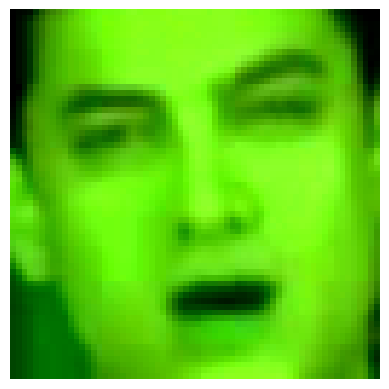

In [36]:
# Test the transforms method, and debug using cell output. 
import matplotlib.pyplot as plt
video = VideoDecoder("data/CelebDF(v2)/test/real/id0_0000.mp4") 
transform = PreprocessVideos()
result_video = transform(video)
result: torch.Tensor = result_video
result = result.permute(1, 2, 3, 0)
plt.imshow(result[0])
plt.axis(False)

In [37]:
import os
from typing import Dict, List, Tuple
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in the target directories"""
    # 1. Get the class names by scanning the entire target directory
    classes = sorted([entry.name for entry in list(os.scandir(directory))])
    
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}...please check file structure")
    
    # 3. Create a list of index labels (computers perfer numbers over strings for labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

## Storing the Data: Dataset and DataLoader
Now that the data can be appropriately transformed into tensors despite being video objects, it is time to create a dataset and a dataloader so that the model created to classify apart deepfakes from real videos. The goals for this section are the following: 
1. Subclass torch.utils.data.Dataset
2. Init our subclass with a target directory (especially of we want to transform our data)
3. Create several attributes
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - the list of the target classes (or labels)
    * classes_to_idx - the dict of the class labels mapped to integer labels.
4. Create a function to load_images() to be able to load any image in the data.
5. Overwrite len() method to return the length of our dataset.
6. Overwrite get_item() to return a given sample when an index is passed.
7. Create datasets for training, testing, and validation sets. 
8. Create dataloaders for training, validation, and testing using the created datasets in the prior steps. 


In [38]:
import torch
from torch.utils.data import Dataset
from torchcodec.decoders import VideoDecoder
from pathlib import Path

# 1. Subclass torch.utils.data.Dataset
class VideoFolderCustom(Dataset):
    # 2. Initialize custom dataset
    def __init__(self, targ_dir: str, transform=None):
        super().__init__()
        # 3. Create (several) class attributes
        # paths
        self.paths = list(Path(targ_dir).glob("*/*.mp4"))
        # transform(s)
        self.transform = transform
        # Classes and classes to idx
        self.classes, self.classes_to_idx = find_classes(targ_dir)

    # 4. Create a function to load videos
    def load_video(self, idx: int) -> VideoDecoder:
        """Opens a video using a path and returns it."""
        video_path = self.paths[idx]
        return VideoDecoder(video_path)        
    
    # 5. Overwrite __len__() method...
    def __len__(self) -> int:
        """Returns the total number of videos in the dataset"""
        return len(self.paths)
    
    # 6. Overwrite __get_item__() method...
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X, y)"""
        video = self.load_video(index)
        class_name = self.paths[index].parent.name
        class_idx = self.classes_to_idx[class_name]
        # Transforms
        if self.transform:
            return self.transform(video), class_idx
        else:
            return torch.tensor(video), class_idx

In [52]:
# Creating the directories as strings
train_dir = "data/CelebDF(v2)/train"
validation_dir = "data/CelebDF(v2)/validation"
test_dir = "data/CelebDF(v2)/test"

In [53]:
# Create the datasets for training, testing, validation
train_dataset = VideoFolderCustom(
    targ_dir=train_dir,
    transform=PreprocessVideos()
)
validation_dataset = VideoFolderCustom(
    targ_dir=validation_dir,
    transform=PreprocessVideos()
)
test_dataset = VideoFolderCustom(
    targ_dir=test_dir,
    transform=PreprocessVideos()
)
train_dataset, validation_dataset, test_dataset

(<__main__.VideoFolderCustom at 0x7ebaf88b8590>,
 <__main__.VideoFolderCustom at 0x7ebaf8960cb0>)

In [54]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS: int = os.cpu_count() # type: ignore
# Create the dataloader from the datasets...
train_dl = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)
validation_dl = DataLoader(
    dataset=validation_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)
test_dl = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)
train_dl, validation_dl, test_dl

(<torch.utils.data.dataloader.DataLoader at 0x7ebaf8792cf0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ebaf8793230>)

/tmp/ipykernel_4109/2089160845.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(img).permute(1, 2, 0).numpy()


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

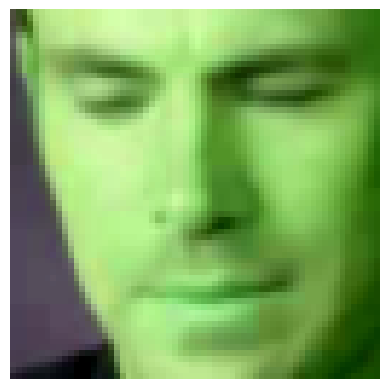

In [55]:
import matplotlib.pyplot as plt
# Testing: display a video frame from the validation set
torch.manual_seed(42)
video = validation_dataset[0][0]
plt.imshow(video.permute(1, 2, 3, 0)[0])
plt.axis(False)

In [ ]:
from torch import nn
### Finally, coding a TinyVGG-LSTM model...
